# Importing Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.optim
from functions.models.optim import *

from skimage.measure import compare_psnr
from functions.models import *
from copy import deepcopy
from functions.utils.global_parameters import *
from functions.utils.common_utils import torch_to_np
from IPython.core.debugger import set_trace

import matplotlib.pyplot as plt
import numpy as np
import cv2

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
#dtype = torch.cuda.FloatTensor
dtype = torch.FloatTensor

In [ ]:
def dip(img_np, arch = 'default', LR = 0.01, num_iter = 1000, reg_noise_std = 1.0/30,exp_weight = 0.99, INPUT = 'noise', save = False, save_path = '', plot = True, input_depth = None, name = None, loss_fn = "MSE", OPTIMIZER = "adam", pad = 'zero',  OPT_OVER = 'net' ):
    
    glparam = global_parameters()
    glparam.set_params(save, plot, reg_noise_std, exp_weight)
    glparam.load_images(img_np)
    glparam.img_torch = glparam.img_torch.type(dtype)
    
    if arch == 'simple':
        if input_depth == None:
            input_depth = 3 
        glparam.net = get_net(input_depth,'skip', pad,
                skip_n33d=16, 
                skip_n33u=16, 
                skip_n11=0, 
                num_scales=3,
                upsample_mode='bilinear').type(dtype)
    else:
        assert False

    net_input = get_noise(input_depth, INPUT, (glparam.img_np.shape[1], glparam.img_np.shape[2])).type(dtype).detach()   
    glparam.net_input_saved = net_input.detach().clone()
    glparam.noise = net_input.detach().clone()
    
    # Compute number of parameters
    param_numbers  = sum([np.prod(list(p.size())) for p in glparam.net.parameters()]) 
    print ('\n Number of params: %d' % param_numbers)

    # Loss function
    if loss_fn == 'MSE':
        criterion = torch.nn.MSELoss().type(dtype)
    if loss_fn == 'KLDiv':
        criterion = torch.nn.KLDivLoss().type(dtype)
        
    if save == True:
        f= open("{}/Stats.txt".format(save_path),"w+")
        f.write("{:>11}{:>12}{:>12}\n".format('Iterations','Total_Loss','PSNR'))
        save_net_details(save_path, arch, param_numbers, pad, OPT_OVER, OPTIMIZER, input_depth,
                 loss_fn = loss_fn, LR = LR, num_iter = num_iter, exp_weight = glparam.exp,
                 reg_noise_std = reg_noise_std, INPUT = 'INPUT', net = glparam.net)
                
    def closure(iter_value):
        show_every = 100
        figsize = 4
        
        ## Initialiaze/ Update variables
        if glparam.noise_std > 0.0:
            net_input = glparam.net_input_saved + (glparam.noise.normal_() * glparam.noise_std)
        net_input = torch.tensor(net_input, dtype=torch.float32, requires_grad=True)
        out = glparam.net(net_input)#, requires_grad=True)

        ## Exponential Smoothing
        if glparam.out_avg is None:
            glparam.out_avg = out.detach()
        else:
            glparam.out_avg = glparam.out_avg * glparam.exp + out.detach() * (1 - glparam.exp)
        
        ## Calculate loss
        total_loss = criterion(out, glparam.img_torch)
        set_trace()
        total_loss.backward()
        set_trace()
        
        glparam.psnr_noisy = compare_psnr(glparam.img_np, out.detach().cpu().numpy()[0]).astype(np.float32)
            
        print ('DIP Iteration {:>11}   Loss {:>11.7f}   PSNR_noisy: {:>5.4f}'.format(
            iter_value, total_loss.item(), glparam.psnr_noisy), end='\r')
        
        ## Backtracking   
        if (glparam.psnr_noisy_last - glparam.psnr_noisy) > 5.0:
            glparam.interrupts = glparam.interrupts + 1
            print('\n Falling back to previous checkpoint.')
            glparam.net.load_state_dict(glparam.last_net.state_dict())
            glparam.optimizer.load_state_dict(glparam.optimizer_last.state_dict())
            
            if glparam.interrupts > 3:
                glparam.psnr_noisy_last = glparam.psnr_noisy
                
            if OPTIMIZER == "adam":     
                for j in range(iter_value % show_every - 1):                
                    glparam.optimizer.zero_grad()
                    closure(iter_value - (iter_value % show_every) + j + 1)
                    glparam.optimizer.step()
                glparam.optimizer.zero_grad()
                closure(iter_value)          
                print('\n Return back to the original')                        
                return total_loss 
            
            if OPTIMIZER == "EntropySGD":
                for j in range(iter_value % show_every - 1):
                    glparam.optimizer.zero_grad()
                    glparam.optimizer.step(iter_value - (iter_value % show_every) + j + 1, closure, glparam.net, criterion)
                glparam.optimizer.zero_grad()
                closure(iter_value)   
                print('\n Return back to the original')                        
                return total_loss                      
            
        if (iter_value % show_every) == 0: 
            glparam.last_net = deepcopy(glparam.net)
            glparam.psnr_noisy_last = glparam.psnr_noisy
            glparam.optimizer_last = deepcopy(glparam.optimizer)
            
            if glparam.interrupts > 3 :
                print("\n Error, was not able to converge after reset")
            glparam.interrupts = 0
            
            if glparam.PLOT:
                fig=plt.figure(figsize=(16, 16))
                fig.add_subplot(1, 3, 1)
                plt.imshow(np.clip(torch_to_np(out), 0, 1).transpose(1, 2, 0))
                plt.title('Output')
                fig.add_subplot(1, 3, 2)
                plt.imshow(np.clip(torch_to_np(glparam.out_avg), 0, 1).transpose(1, 2, 0))
                plt.title('Averaged Output')
                fig.add_subplot(1, 3, 3)
                plt.title('Original/Target')
                plt.imshow(glparam.img_np.transpose(1, 2, 0))
                plt.show()
                
            if glparam.save:
                f = open("{}/Stats.txt".format(save_path),"a")
                f.write("{:>11}{:>12.8f}{:>12.8f}\n".format(iter_value, total_loss.item(), glparam.psnr_noisy))
                plt.imsave("{}/it_{}.png".format(save_path,iter_value),
                       np.clip(torch_to_np(glparam.out_avg), 0, 1).transpose(1,2,0), format="png")
                
        return total_loss
        
    ### Optimize
    glparam.net.train()
    p = get_params(OPT_OVER, glparam.net, net_input)
    
    if OPTIMIZER == "adam":
        glparam.optimizer = torch.optim.Adam(p, lr = LR)
        for j in range(num_iter):
            glparam.optimizer.zero_grad()
            closure(j)
            glparam.optimizer.step()            
    if OPTIMIZER == "EntropySGD":
        glparam.optimizer = EntropySGD(p,config=dict(lr = LR))
        for j in range(num_iter):
            glparam.optimizer.zero_grad()
            glparam.optimizer.step(j, closure, glparam.net, criterion)    
    print('\n')       
    
    out = glparam.net(net_input)
    glparam.out_avg = glparam.out_avg * glparam.exp + out.detach() * (1 - glparam.exp)
    return glparam.out_avg

In [ ]:
import cv2
img = cv2.imread('data/goldfish.jpg')[..., ::-1]
img_np = np.array(img)
_, dip(img_np, arch = 'simple')

In [5]:
image_dataset = ['it_0.png', 'it_100.png']
image_dataset.append(['it_{}.png'.format(100*i) for i in range(60, 101)])

In [6]:
print(image_dataset)

['it_0.png', 'it_100.png', ['it_6000.png', 'it_6100.png', 'it_6200.png', 'it_6300.png', 'it_6400.png', 'it_6500.png', 'it_6600.png', 'it_6700.png', 'it_6800.png', 'it_6900.png', 'it_7000.png', 'it_7100.png', 'it_7200.png', 'it_7300.png', 'it_7400.png', 'it_7500.png', 'it_7600.png', 'it_7700.png', 'it_7800.png', 'it_7900.png', 'it_8000.png', 'it_8100.png', 'it_8200.png', 'it_8300.png', 'it_8400.png', 'it_8500.png', 'it_8600.png', 'it_8700.png', 'it_8800.png', 'it_8900.png', 'it_9000.png', 'it_9100.png', 'it_9200.png', 'it_9300.png', 'it_9400.png', 'it_9500.png', 'it_9600.png', 'it_9700.png', 'it_9800.png', 'it_9900.png', 'it_10000.png']]


In [3]:
'it_' + 100*i + '.png'

NameError: name 'i' is not defined

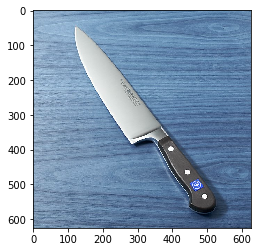

In [16]:
import cv2
import matplotlib.pyplot as plt
img = cv2.imread('data/knife.jpg')

plt.imshow(img)
plt.show()

In [8]:
img

array([[[148, 175, 202],
        [144, 171, 198],
        [141, 168, 195],
        ...,
        [106, 140, 176],
        [106, 140, 176],
        [103, 134, 173]],

       [[145, 172, 199],
        [143, 170, 197],
        [141, 168, 195],
        ...,
        [ 97, 131, 167],
        [ 99, 133, 169],
        [103, 134, 173]],

       [[152, 179, 206],
        [152, 179, 206],
        [152, 179, 206],
        ...,
        [ 96, 130, 166],
        [ 95, 129, 165],
        [104, 138, 174]],

       ...,

       [[107, 137, 164],
        [107, 137, 164],
        [113, 143, 170],
        ...,
        [ 56,  80, 110],
        [ 57,  81, 111],
        [ 65,  86, 117]],

       [[122, 151, 178],
        [115, 144, 171],
        [109, 138, 165],
        ...,
        [ 45,  68, 100],
        [ 44,  68,  98],
        [ 53,  74, 106]],

       [[139, 166, 192],
        [151, 178, 204],
        [148, 175, 201],
        ...,
        [ 56,  76, 111],
        [ 56,  77, 109],
        [ 61,  81, 116]]